In [ ]:
from twoRegionSim import twoRegionMultiInput
from src.dataHandling import loadData, makeVoltageDF,makeRateDF,makeInputDF,saveData
from plotting.plotAcrossTime import plotConstantInputAcrossTime,plotVoltageAcrossTime,plotRateAcrossTime
from plotting.plotAcrossInput import plotAverageVoltageAcrossInput,plotStdVoltageAcrossInput,splitFrameAcrossInput
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import itertools
from tqdm import tqdm
import colour

In [ ]:
def runFeedbackSearch(r1EToR2EWeight=1.1,r1EToR2IWeight=1.1,feedbackStr=[.5],feedbackEIRatio=np.linspace(.5,1.5,8),
                      r1InputAmplitudes = np.array([np.linspace(0,10,201)]).T,r2InputAmplitudes=np.array([np.zeros(201)]).T,
                      repeats=10,timeLength=7500,divisions=25000):
    assert len(r1InputAmplitudes) == len(r2InputAmplitudes)
    inputIndex = list(range(len(r1InputAmplitudes)))
    paramIterator = list(itertools.product(feedbackStr,feedbackEIRatio,inputIndex))*repeats
    paramIndexedProduct = list(enumerate(paramIterator))
    saveData({'paramProduct':paramIndexedProduct,'r1Inputs':r1InputAmplitudes,'r2Inputs':r2InputAmplitudes},'./twoRegion/data/feedback/indexer.pkl')
    for index,params in tqdm(paramIndexedProduct):
        runFeedbackStr = params[0]
        runFeedbackEIRatio = params[1]
        runR1InputAmplitudes = r1InputAmplitudes[params[2]]
        runR2InputAmplitudes = r2InputAmplitudes[params[2]]
        r2EtoR1EWeight = runFeedbackStr
        r2EToR1IWeight = runFeedbackStr/runFeedbackEIRatio
        twoRegionMultiInput(r1EToR2EWeight=r1EToR2EWeight,r1EToR2IWeight=r1EToR2IWeight,
                            r1IToR2EWeight=0,r1IToR2IWeight=0,
                            r2EToR1EWeight=r2EtoR1EWeight,r2EToR1IWeight=r2EToR1IWeight,r2IToR1EWeight=0,r2IToR1IWeight=0,
                            eulerTimeEnd=timeLength,divisions=divisions,r1InputAmplitudes=runR1InputAmplitudes,
                            r2InputAmplitudes = runR2InputAmplitudes,
                            saveName=f'feedback/feedbackSim{index}',progressBar=False)
runFeedbackSearch()

In [ ]:
def getFileNamesWithinStimulus(folder,fileFunction):
    indexer = loadData(f'{folder}/indexer.pkl')
    params = [label[1] for label in indexer['paramProduct']]
    uniqueParams = list(set(params))
    outDict = {}
    for uniqueParam in uniqueParams:
        outDict[uniqueParam] = [f'{folder}/{fileFunction(param[0])}' for param in indexer['paramProduct'] if param[1] == uniqueParam]
    return outDict,indexer['r1Inputs'],indexer['r2Inputs']

def feedbackFileFunc(index):
    return f'feedbackSim{index}.pkl'

def loadFileDictFrames(fileDict,frameTransform,removeNull=True):
    paramDict = {}
    for (param,fnames) in fileDict.items():
        frames = [frameTransform(loadData(fname)) for fname in fnames]
        if removeNull:
            if not any([frame.isnull().values.any() for frame in frames]):
                paramDict[param] = frames
        else:
            paramDict[param] = frames
    return paramDict

def averageVoltageTransform(dataDict):
    return makeVoltageDF(dataDict).mean(axis=0)

def stdVoltageTransform(dataDict):
    return makeVoltageDF(dataDict).std(axis=0)

def averageRateTransform(dataDict):
    return makeRateDF(dataDict).mean(axis=0)

def covarianceRateTransform(dataDict):
    return makeRateDF(dataDict).cov()

def averageWithinStimulus(frameDict):
    newDict = {}
    for key,value in frameDict.items():
        newDict[key] = sum(value)/len(value)
    return newDict

def makeStimDataFrame(voltageDictValue,r1Inputs):
    keys = list(voltageDictValue.keys())
    eiRatio = [key[1] for key in keys]
    inputs = [key[2] for key in keys]
    eiIndex = sorted(list(set((eiRatio))))
    inputsIndex = sorted(list(set(inputs)))
    inputR1Stims = [r1Inputs[index][0] for index in inputsIndex]
    r1EDF=pd.DataFrame(data=None,index=eiIndex,columns=inputR1Stims)
    r1IDF=pd.DataFrame(data=None,index=eiIndex,columns=inputR1Stims)
    r2EDF=pd.DataFrame(data=None,index=eiIndex,columns=inputR1Stims)
    r2IDF=pd.DataFrame(data=None,index=eiIndex,columns=inputR1Stims)
    for keyIndex,key in enumerate(keys):
        row = eiRatio[keyIndex]
        col = r1Inputs[inputs[keyIndex]][0]
        r1EDF.loc[row,col] = voltageDictValue[key]['r1E']
        r1IDF.loc[row,col] = voltageDictValue[key]['r1I']
        r2EDF.loc[row,col] = voltageDictValue[key]['r2E']
        r2IDF.loc[row,col] = voltageDictValue[key]['r2I']
    return r1EDF,r1IDF,r2EDF,r2IDF


fileDict,r1Inputs,r2Inputs = getFileNamesWithinStimulus("./twoRegion/data/feedback",feedbackFileFunc)

voltageFrameMean = loadFileDictFrames(fileDict,averageVoltageTransform)
voltageFrameStd = loadFileDictFrames(fileDict,stdVoltageTransform)
rateFrameMean = loadFileDictFrames(fileDict,averageRateTransform)
voltageFrameMeanAv = averageWithinStimulus(voltageFrameMean)
voltageFrameStdAv = averageWithinStimulus(voltageFrameStd)
rateFrameMeanAv = averageWithinStimulus(rateFrameMean)

r1EDFMean,r1IDFMean,r2EDFMean,r2IDFMean = makeStimDataFrame(voltageFrameMeanAv,r1Inputs)
r1EDFStd,r1IDFStd,r2EDFStd,r2IDFStd = makeStimDataFrame(voltageFrameStdAv,r1Inputs)
r1ERateMean,r1IRateMean,r2ERateMean,r2IRateMean = makeStimDataFrame(rateFrameMeanAv,r1Inputs)



In [78]:
def derivativeEstimate(df:pd.DataFrame):
    diffDf = df.diff(axis=1)
    diffDf.dropna(axis=1,inplace=True)
    diffIndex = df.columns[1:]-df.columns[:len(df.columns)-1]
    return diffDf/diffIndex
def covarianceRateTransform(dataDict):
    return makeRateDF(dataDict).cov()
def makeLinearFisher(r1ERateMean,r1IRateMean,r2ERateMean,r2IRateMean):
    rateFrameCov = loadFileDictFrames(fileDict,covarianceRateTransform)
    rateFrameCovAv = averageWithinStimulus(rateFrameCov)
    r1ERateDer,r1IRateDer,r2ERateDer,r2IRateDer = derivativeEstimate(r1ERateMean),derivativeEstimate(r1IRateMean),derivativeEstimate(r2ERateMean),derivativeEstimate(r2IRateMean)
    stimToIndex = {r1ERateDer.columns[i]:i for i in range(len(r1ERateDer.columns))}
    fisherInformation = pd.DataFrame(None,index=r1ERateDer.index,columns=r1ERateDer.columns)
    r1EFisher = pd.DataFrame(None,index=r1ERateDer.index,columns=r1ERateDer.columns)
    r1IFisher = pd.DataFrame(None,index=r1ERateDer.index,columns=r1ERateDer.columns)
    r2EFisher = pd.DataFrame(None,index=r1ERateDer.index,columns=r1ERateDer.columns)
    r2IFisher = pd.DataFrame(None,index=r1ERateDer.index,columns=r1ERateDer.columns)
    for col in r1ERateDer.columns:
        for row in r1ERateDer.index:
            stimIndex = stimToIndex[col]
            cov = rateFrameCovAv[(.5,row,stimIndex)]
            derivativeVector = np.array([[r1ERateDer.loc[row,col]],
                                        [r1IRateDer.loc[row,col]],
                                        [r2ERateDer.loc[row,col]],
                                        [r2IRateDer.loc[row,col]]])
            fisherInformation.loc[row,col] = np.matmul(derivativeVector.T,np.matmul(np.linalg.inv(cov),derivativeVector))[0,0]
            individualLinearFisher = 1/np.diag(cov)*derivativeVector**2
            r1EFisher.loc[row,col] = individualLinearFisher[0,0]
            r1IFisher.loc[row,col] = individualLinearFisher[1,0]
            r2EFisher.loc[row,col] = individualLinearFisher[2,0]
            r2IFisher.loc[row,col] = individualLinearFisher[3,0]
    return fisherInformation,r1EFisher,r1IFisher,r2EFisher,r2IFisher

totalLinearFisher,r1ELinearFisher,r1ILinearFisher,r2ELinearFisher, r2ILinearFisher = makeLinearFisher(r1ERateMean,r1IRateMean,r2ERateMean,r2IRateMean)



Makes all the necessary plotting functions

In [122]:
def colorRange(baseColor,toColor,number):
    baseColorRGB = colour.Color(baseColor).rgb
    toColorRGB = colour.Color(toColor).rgb
    colors = [baseColorRGB, toColorRGB]
    cm = LinearSegmentedColormap.from_list("Custom", colors, N=number) 
    return cm

def plotMeanInputAcrossEI(meanFrame,ax,baseColor='red',title='Average Response Across EI Ratio',
                      xTicks="implied",yTicks="implied",showXLabel=True,showYLabel=True,yLabel='Voltage',maxDisplay=7):
    if maxDisplay >= len(meanFrame.index):
        indexes = meanFrame.index
    else:
        plotIndexJump = len(meanFrame.index)/maxDisplay
        indexes = [*[int(x*plotIndexJump) for x in range(maxDisplay)],len(meanFrame.index)-1]
    colorMap = colorRange('black',baseColor,len(indexes))
    colors = [colorMap(i) for i in range(len(indexes))]
    frame = meanFrame
    for i in range(len(indexes)):
        if i == 0:
            frame.iloc[indexes[i],:].plot(ax=ax,c=colors[i],label=f'{meanFrame.index[indexes[i]]} EI')
        elif i == len(meanFrame.index)-1:
            frame.iloc[indexes[i],:].plot(ax=ax,c=colors[i],label=f'{meanFrame.index[indexes[i]]} EI')
        else:
            frame.iloc[indexes[i],:].plot(ax=ax,c=colors[i],label='_nolegend_')
    ax.legend()
    ax.set_title(title)
    if showYLabel:
        ax.set_ylabel(yLabel)
    if showXLabel:
        ax.set_xlabel('Input Strength')
    if not type(xTicks) == str:
        ax.set_xticks(xTicks)
    if not type(yTicks) == str:
        ax.set_yticks(yTicks)
colorMapping = {'r1E':'red','r1I':'blue','r2E':'orange','r2I':'purple'}

plots the voltage, voltage std, and rate

/tmp/ipykernel_30580/2581915609.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (xTicks == "implied"):
/tmp/ipykernel_30580/2581915609.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (yTicks == "implied"):
/tmp/ipykernel_30580/2581915609.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (xTicks == "implied"):
/tmp/ipykernel_30580/2581915609.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (yTicks == "implied"):
/tmp/ipykernel_30580/2581915609.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (xTicks == "implied"):
/tmp/ipykernel_

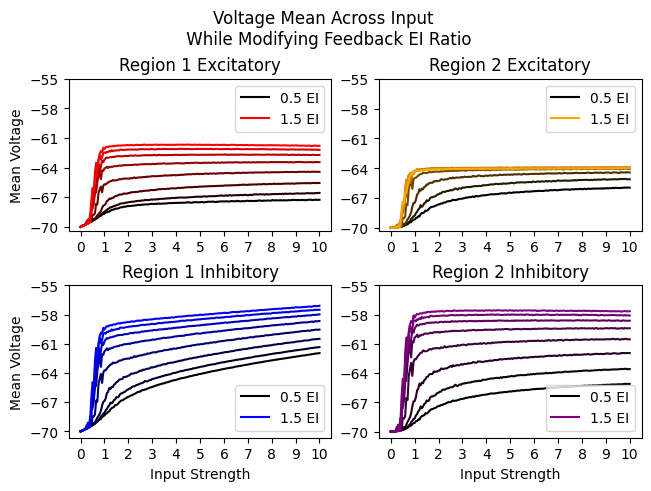

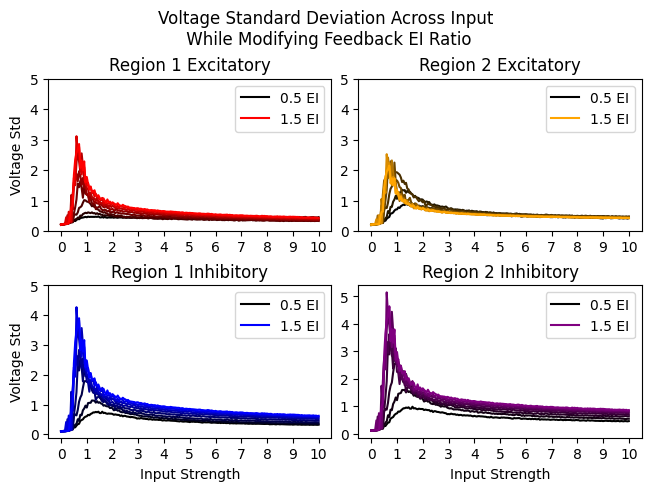

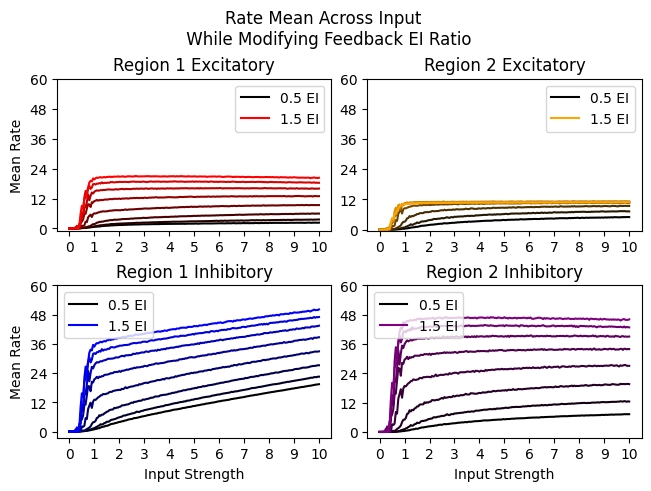

In [128]:
#average voltage plot
fig,axs = plt.subplots(2,2,layout='constrained')
plt.suptitle('Voltage Mean Across Input \n While Modifying Feedback EI Ratio')
plotYTicks = np.linspace(-70,-55,6)
plotXTicks = np.linspace(0,10,11)
plotMeanInputAcrossEI(r1EDFMean,axs[0,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1E'],showXLabel=False,title='Region 1 Excitatory',yLabel='Mean Voltage')
plotMeanInputAcrossEI(r1IDFMean,axs[1,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1I'],title='Region 1 Inhibitory',yLabel='Mean Voltage')
plotMeanInputAcrossEI(r2EDFMean,axs[0,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2E'],showXLabel=False,showYLabel=False,title='Region 2 Excitatory')
plotMeanInputAcrossEI(r2IDFMean,axs[1,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2I'],showYLabel=False,title='Region 2 Inhibitory')
plt.savefig('./twoRegion/figs/EIRatioVoltageMean.png')
#std voltage plot
fig,axs = plt.subplots(2,2,layout='constrained')
plt.suptitle('Voltage Standard Deviation Across Input\n While Modifying Feedback EI Ratio')
plotYTicks = np.linspace(0,5,6)
plotXTicks = np.linspace(0,10,11)
plotMeanInputAcrossEI(r1EDFStd,axs[0,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1E'],showXLabel=False,title='Region 1 Excitatory',yLabel='Voltage Std')
plotMeanInputAcrossEI(r1IDFStd,axs[1,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1I'],title='Region 1 Inhibitory',yLabel='Voltage Std')
plotMeanInputAcrossEI(r2EDFStd,axs[0,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2E'],showXLabel=False,showYLabel=False,title='Region 2 Excitatory')
plotMeanInputAcrossEI(r2IDFStd,axs[1,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2I'],showYLabel=False,title='Region 2 Inhibitory')
plt.savefig('./twoRegion/figs/EIRatioVoltageStd.png')
#average rate plot
fig,axs = plt.subplots(2,2,layout='constrained')
plt.suptitle('Rate Mean Across Input \n While Modifying Feedback EI Ratio')
plotYTicks = np.linspace(0,60,6)
plotXTicks = np.linspace(0,10,11)
plotMeanInputAcrossEI(r1ERateMean,axs[0,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1E'],showXLabel=False,title='Region 1 Excitatory',yLabel='Mean Rate')
plotMeanInputAcrossEI(r1IRateMean,axs[1,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1I'],title='Region 1 Inhibitory',yLabel='Mean Rate')
plotMeanInputAcrossEI(r2ERateMean,axs[0,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2E'],showXLabel=False,showYLabel=False,title='Region 2 Excitatory')
plotMeanInputAcrossEI(r2IRateMean,axs[1,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2I'],showYLabel=False,title='Region 2 Inhibitory')
plt.savefig('./twoRegion/figs/EIRatioRateMean.png')

plots the linear fisher information

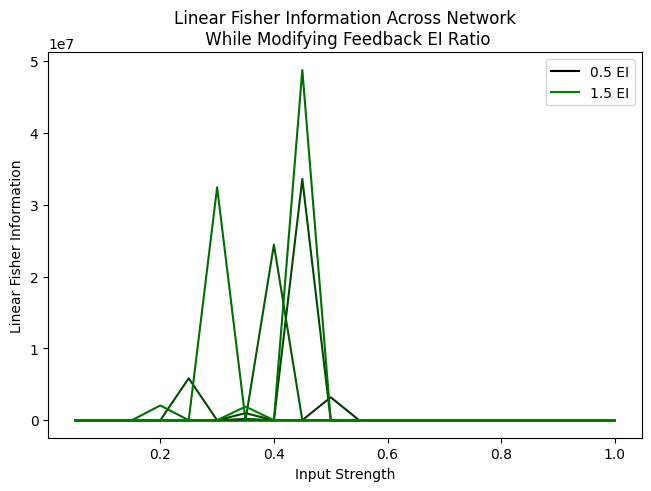

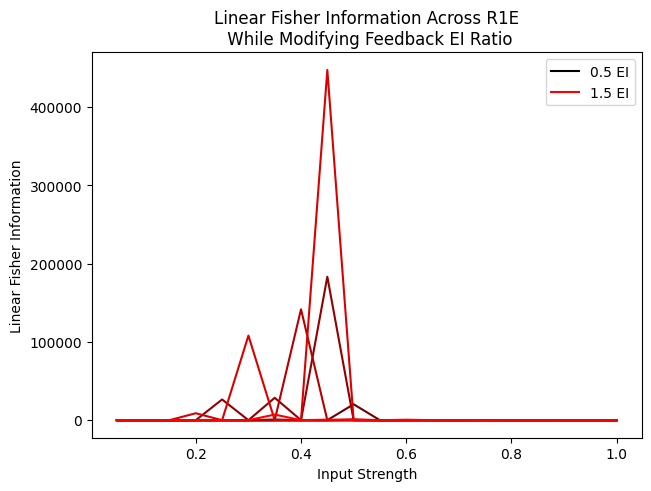

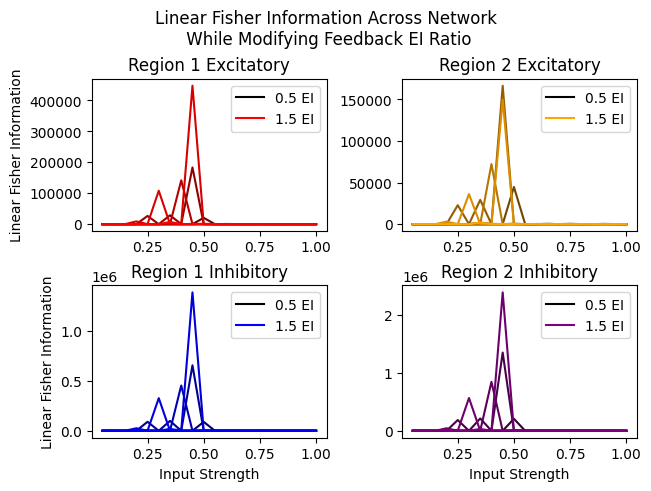

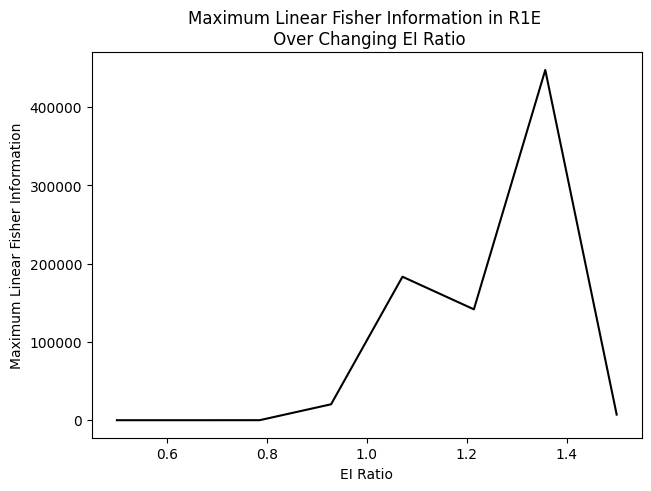

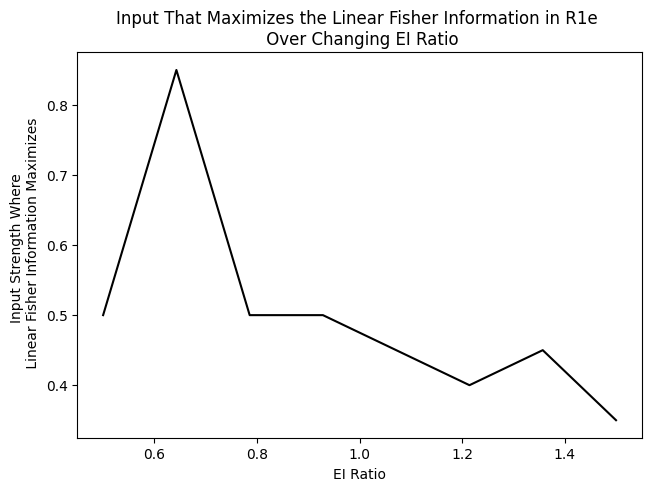

In [127]:
#plots the total network linear fisher information
fig,axs = plt.subplots(1,layout='constrained')
plotMeanInputAcrossEI(totalLinearFisher.iloc[:,:20],axs,yLabel='Linear Fisher Information',
                      baseColor='green',title='Linear Fisher Information Across Network\n While Modifying Feedback EI Ratio')
plt.savefig('./twoRegion/figs/totalLinearFisher.png')
#plots the linear fisher information for r1e
fig,axs = plt.subplots(1,layout='constrained')
plotMeanInputAcrossEI(r1ELinearFisher.iloc[:,:20],axs,yLabel='Linear Fisher Information',
                      baseColor=colorMapping['r1E'],title='Linear Fisher Information Across R1E\n While Modifying Feedback EI Ratio')
plt.savefig('./twoRegion/figs/R1ELinearFisher.png')
#plots the linear fisher information for all regions
fig,axs = plt.subplots(2,2,layout='constrained')
plt.suptitle('Linear Fisher Information Across Network\n While Modifying Feedback EI Ratio')
plotMeanInputAcrossEI(r1ELinearFisher.iloc[:,:20],axs[0,0],baseColor=colorMapping['r1E'],showXLabel=False,title='Region 1 Excitatory',yLabel='Linear Fisher Information')
plotMeanInputAcrossEI(r1ILinearFisher.iloc[:,:20],axs[1,0],baseColor=colorMapping['r1I'],title='Region 1 Inhibitory',yLabel='Linear Fisher Information')
plotMeanInputAcrossEI(r2ELinearFisher.iloc[:,:20],axs[0,1],baseColor=colorMapping['r2E'],showXLabel=False,showYLabel=False,title='Region 2 Excitatory')
plotMeanInputAcrossEI(r2ILinearFisher.iloc[:,:20],axs[1,1],baseColor=colorMapping['r2I'],showYLabel=False,title='Region 2 Inhibitory')
plt.savefig('./twoRegion/figs/combinedLinearFisher.png')
#plots the maximum linear fisher information for region 1 e
fig,axs = plt.subplots(1,layout='constrained')
plt.plot(r1ELinearFisher.max(axis=1),color='black')
plt.title('Maximum Linear Fisher Information in R1E \n Over Changing EI Ratio')
plt.xlabel('EI Ratio')
plt.ylabel('Maximum Linear Fisher Information')
plt.savefig('./twoRegion/figs/r1EMaximumLinearFisher.png')
#plots the input where the maximum linear fisher information occurs
fig,axs = plt.subplots(1,layout='constrained')
plt.plot(r1ELinearFisher.index,[r1ELinearFisher.columns[i] for i in np.argmax(r1ELinearFisher,axis=1)],color='black')
plt.title('Input That Maximizes the Linear Fisher Information in R1e \n Over Changing EI Ratio')
plt.xlabel('EI Ratio')
plt.ylabel('Input Strength Where \n Linear Fisher Information Maximizes')
plt.savefig('./twoRegion/figs/r1EArgmaxLinearFisher.png')